In [2]:
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy
from sklearn.metrics import mean_squared_error

from lib.util.env import getbase_dir
import matplotlib.ticker as ticker

 # Metodos

In [3]:
def readResultsSPF02():
    df = pd.read_csv(getbase_dir(['results','sbf_data']) + 'msplit_' +'bikes' + '.csv', sep=';')
    df['ds'] = 'bike'
#     df = df[df.bf_type != 'BBLIP']

    for ds in ['beer', 'books1', 'eletronics', 'movies1', 'music', 'restaurants1' , 'NCVR' , 'MVR' , 'yv-er']:
        bdf = pd.read_csv(getbase_dir(['results','sbf_data']) + 'msplit_' + ds + '.csv', sep=';',low_memory=False)
        bdf['ds'] = ds
#         bdf = bdf[bdf.bf_type != 'BBLIP']
        df = pd.concat([df, bdf])

    return df

In [4]:
def dataExtract_exp01(bbf_df):
    """
    Processa os resultados e agrupa por similarade (todos os splits eq-01 ou um split eq-2)
    :param bbf_df: o dataset com os resultados
    :return:
    """
    bbf_df = bbf_df.round(2)
    bbf_df['exp_01'] = bbf_df.full - bbf_df.sbf_sim

    z = []
    for i in bbf_df.splits.unique():
        for j in bbf_df.bf_type.unique():
            # temp = bbf_df[(bbf_df.splits == i) & (bbf_df.ds == j)]
            temp = bbf_df[(bbf_df.splits == i) & (bbf_df.bf_type == j)]

            # if i < 129:
            # temp = bbf_df[(bbf_df.splits == i)]
            # bbf_df['exp_01_std'] = np.std(temp.exp_01)

            out = {'splits': i, 'similarity': 'all-splits', 'bf_type' : j
                    ,'mean_erro': np.mean(temp.exp_01),
                   'std': np.std(temp.exp_01)
                   }
            z.append(out)

            # eq1 mean
            out = {'splits': i, 'similarity': 'one-split','bf_type' :  j,
                   'mean_erro': np.mean(temp.mean_dist_of_real),
                   'std': np.std(temp.mean_dist_of_real)
                   }
            z.append(out)

            # out = {'splits': i, 'ds': 'eq2-max',
            #        'mean_erro': np.mean(temp.max_dist_of_real),
            #        'std': np.std(temp.max_dist_of_real)
            #        }
            # z.append(out)

            # out = {'splits': i, 'ds': 'eq2-min',
            #        'mean_erro': np.mean(temp.min_dist_of_real),
            #        'std': np.std(temp.min_dist_of_real)
            #        }
            # z.append(out)

    return pd.DataFrame(z).round(2)

## Graficos

In [5]:
def plot_all_ds_considering_split_number(df,dash_styltes,columns=1):
    """
    Equation 01 of section 2

    :param df:
    :param dash_styltes:
    :return:
    """
    
    if columns == 1:
        fig_width = 4.8
    else:
        fig_width = 12
            
    golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
    fig_height = fig_width*golden_mean # height in inches
    
    fig_height = fig_width * 0.9
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    sns.lineplot(data=df, x='splits', y='mean_erro',hue='bf_type',
                 style='similarity',dashes=dash_styles)
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.xaxis.set_major_locator(ticker.LogLocator(base=2.0, subs=(1.0, ), numdecs=0, numticks=None))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    # ax.axhline(0.01, ls='--')

#     plt.title("Similarity Error")
    # plt.ylabel("Error (\u03B5)")
    plt.ylabel("Error")
    plt.xlabel("Number of splits")

    plt.show()
    fig.savefig(getbase_dir(['results','figs']) + "zz_all_ds_considering_split_number.png", dpi=100)
    fig.savefig(getbase_dir(['results','figs']) + "zz_all_ds_considering_split_number.pdf")
    
#     matplotlib.use("pgf")
#     matplotlib.rcParams.update({
#         "pgf.texsystem": "pdflatex",
#         'font.family': 'serif',
#         'text.usetex': True,
#         'text.latex.unicode' : True,
#         'pgf.rcfonts': False,
#         'figure.figsize': [fig_width,fig_height],
#         'font.family': 'sans-serif',
#         'font.sans-serif' : 'Arial',
#     })
    
#     fig.savefig(getbase_dir(['results','vldb']) + "zz_all_ds_considering_split_number.pgf")
    plt.close()


In [6]:
def plot_all_ds_considering_percent(df,dash_styltes,columns=1):
    if columns == 1:
        fig_width = 5
    else:
        fig_width = 12
            
    fig_height = fig_width * 0.75
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    sns.lineplot(data=df, x='x', y='mean_dist_of_real', hue='ds' , dashes=[(2, 2)])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
#     plt.title("SBF Split Error")
    plt.ylabel("Mean Error (\u03B5)")
    plt.xlabel("Split length in % of original filter")

    plt.show()
    fig.savefig(getbase_dir(['results','figs']) + "zz_all_ds_error_bit_percent.png",dpi=150)
    fig.savefig(getbase_dir(['results','figs']) + "zz_all_ds_error_bit_percent.pdf")
    
    plt.close()

## Privacidade

In [51]:
def exponential_regression2var(func_exp,x_data, y_data,label_data,
                               xg, yg , 
                               eq_label=r'$f(x) = {:.2f} * ln( {:.2f} * x) + {:.2f}$'):
    # func_exp = q2
    # x_data = X
    # y_data = y
    # xg = Xg
    
    fig_width = 4.8
    golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio    
    fig_height = fig_width * 0.9
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    popt, pcov = scipy.optimize.curve_fit(func_exp, x_data, y_data, p0 = (-1, 0.01, 0))
#     puntos = plt.plot(xg, yg, 'x', color='lightcoral', label = "error")
    custom_df = pd.DataFrame({'x' : xg, 'y':yg, 'ds':label_data})
    
    pontos = sns.scatterplot(data=custom_df, x="x", y="y",
                             marker='x', hue='ds', s=80,
                             ax=ax)

    y_predicted = func_exp(xg, *popt)
    rmse = np.sqrt(mean_squared_error(yg, y_predicted))

    eq_label = eq_label.format(*popt) + ",\n rmse = {:.3f}".format(rmse)
    curva_regresion, = ax.plot(x_data, func_exp(x_data, *popt),
                               color='gray', alpha=.7,
                               linewidth=3.5, linestyle='--', 
                               label = eq_label)
    
    
    plt.xlabel("$x=\\frac{s}{l}$")
    plt.ylabel('Error')
    
    leg = ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),title= '',fancybox=True, frameon=False , ncol=2)
    plt.tight_layout()

    plt.show()
    plt.close()
    plt.clf()

    fig.savefig(getbase_dir(['results', 'figs']) + "new_estimated_sbf_erro.png", dpi=150)
    fig.savefig(getbase_dir(['results','figs']) + "new_estimated_sbf_erro.pdf")
    plt.close()

    return popt

In [8]:
def plot_error_epsilon_distribution_original(z,marcas=[1, 3, 5, 6],fs=(12, 6)):
    # z = df[df.bf_type == 'BBF']
    # z = df
    z['nd'] = (z.full - z.psim_mean)*100
    # zz = z[z.x <= 0.2]
    # zz = zz[zz.x >= 0.1]

    #fig, ax = plt.subplots()

    #ax.violinplot(zz.nd, vert=True)
    #sns.distplot(zz.nd, fit=st.laplace, kde=False)
    # Show the plot
    #plt.show()

    # labels = list(z.x.unique()[[1, 2, 3, 4, 5, 6]])
    labels = list(z.x.unique()[marcas])
    
    fig, axes = plt.subplots(2, int(len(labels) / 2), figsize=fs,
                             constrained_layout=True ,    
                             sharex=True)
    # fig.subplots_adjust(top=0.8)
#     fig.suptitle("\u03B5-Error Distribution",y=1.05)

    colors = ['skyblue', 'olive', 'gold', 'purple', 'teal', 'red']
    # labels = z.x.unique()

    for x in range(0, len(labels)):
        print(x)
        eixo = False
        if x < len(labels) / 2:
            eixo = axes[0, x]
            # axes[x]
        else:
            eixo = axes[1, int(x - len(labels) / 2)]

        eixo.set_title('Split of {:.2%}'.format(labels[x]))
        # sns.distplot(z[z.x == labels[x]].nd, fit=st.laplace , color=colors[x],
        sns.distplot(z[z.x == labels[x]].nd, fit=st.laplace,
                     label='length={}'.format(x), kde=False,
                     ax=eixo)
        # ax=axes[0,x])

    for ax1 in axes.flat:
        # ax1.set(xlabel='x-label', ylabel='y-label')
        ax1.set(xlabel='error')
    plt.show()
    fig.savefig(getbase_dir(['results', 'figs']) + "zz_p_error_episilon.png", dpi=150)
    fig.savefig(getbase_dir(['results', 'figs']) + "zz_p_error_episilon.pdf")
    

In [9]:
def plot_error_epsilon_distribution(z,marcas=[1, 3, 5, 6],fs=(12, 6)):
    # z = df[df.bf_type == 'BBF']
    # z = df
    z['nd'] = (z.full - z.psim_mean)*100
    # zz = z[z.x <= 0.2]
    # zz = zz[zz.x >= 0.1]

    #fig, ax = plt.subplots()

    #ax.violinplot(zz.nd, vert=True)
    #sns.distplot(zz.nd, fit=st.laplace, kde=False)
    # Show the plot
    #plt.show()

    # labels = list(z.x.unique()[[1, 2, 3, 4, 5, 6]])
    labels = list(z.x.unique()[marcas])
    
    fig, axes = plt.subplots( 1 , 3 , figsize=fs,
                             constrained_layout=True, 
                             sharex=True)
    # fig.subplots_adjust(top=0.8)
#     fig.suptitle("\u03B5-Error Distribution",y=1.05)

    colors = ['skyblue', 'olive', 'gold', 'purple', 'teal', 'red']
    # labels = z.x.unique()

    for x in range(0, len(labels)):
        print(x)
        eixo = False
        eixo = axes[x]
#         if x < len(labels):
#             eixo = axes[0, x]
# #             eixo = axes[x,0]
#             # axes[x]
#         else:
#             eixo = axes[1, int(x - len(labels) / 2)]

        eixo.set_title('Split of {:.2%}'.format(labels[x]))
        # sns.distplot(z[z.x == labels[x]].nd, fit=st.laplace , color=colors[x],
        sns.distplot(z[z.x == labels[x]].nd, fit=st.laplace, label='length={}'.format(x), kde=False, ax=eixo)
        # ax=axes[0,x])

    for ax1 in axes.flat:
        # ax1.set(xlabel='x-label', ylabel='y-label')
        ax1.set(xlabel='error')
    plt.show()
    fig.savefig(getbase_dir(['results', 'figs']) + "zz_p_error_episilon.png", dpi=150)
    fig.savefig(getbase_dir(['results', 'figs']) + "zz_p_error_episilon.pdf")
    

# Analise

In [10]:
dash_styles = ["",
                   (4, 1.5),
                   (1, 1),
                   (3, 1, 1.5, 1),
                   (5, 1, 1, 1),
                   (5, 1, 2, 1, 2, 1),
                   (2, 2, 3, 1.5),
                   (1, 2.5, 3, 1.2),
                   (2, 1),
                   (4, 1.5),
                   (3, 1, 2.5, 1),
                   (5, 1.3, 1.5, 1),
                   ]

In [12]:
df = readResultsSPF02()
z = dataExtract_exp01(df)

In [54]:
# z = dataExtract_exp01(df)
z.loc[(z['bf_type'] == 'BBF') & (z.similarity == 'one-split'), 'mean_erro'] = z[z.bf_type == 'BBF']['mean_erro'] + 0.0051 # dodge hardcoded

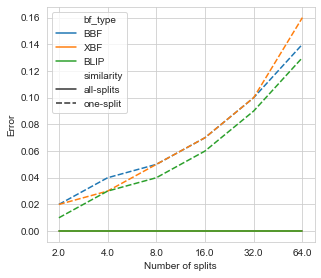

In [55]:
plot_all_ds_considering_split_number(z[z.splits < 128].round(2),dash_styles)

sem os dados pessoais

In [13]:
del z

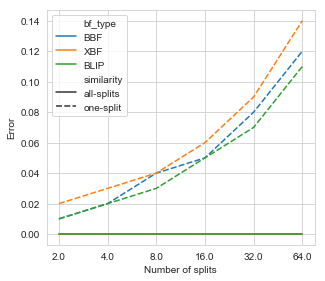

In [15]:
plot_all_ds_considering_split_number(z[z.splits < 128].round(2),dash_styles)

In [57]:
df['x'] = ((df.orignal_bits_size / df.splits) / df.orignal_bits_size)

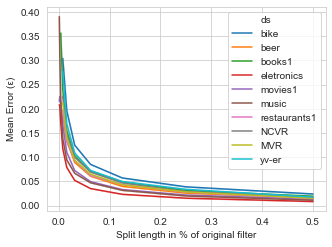

In [58]:
plot_all_ds_considering_percent(df[df.bf_type == 'BBF'], dash_styles)

resultados sem os dados pessoais

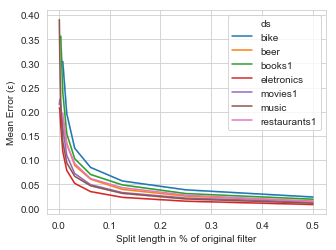

In [16]:
plot_all_ds_considering_percent(df[df.bf_type == 'BBF'], dash_styles)

## Privacidade

In [14]:
    # REGRESSAO PARA MOSTRAR A EQUACAO QUE CASA COM O ERRO
df['x'] = ((df.orignal_bits_size / df.splits) / df.orignal_bits_size)
df.x.unique()
bdf = df[(df.bf_type == 'BBF')]
bdf = df

In [19]:
bdf = bdf[bdf.ds.isin(['bike', 'beer', 'books1', 'eletronics', 'movies1', 'music',
       'restaurants1'])]

In [20]:
X = []
y = []
for x in bdf.x.unique():
    if x != 0.5:
        X.append(x)
        y.append(bdf[bdf.x == x].mean_dist_of_real.mean())

X = np.asarray(X)
y = np.asarray(y)

In [21]:
# X = np.asarray(bdf[['x']]).T[0]
#y = np.asarray(bdf[['mean_dist_of_real']]).T[0]

## plotar com dados individualizados
Xg = []
yg = []
labelg = []
for ids in bdf.ds.unique():
    tz = bdf[bdf.ds == ids]
    for x in bdf[bdf.ds == ids].x.unique():
        if x != 0.5 and x > 0.01:
            Xg.append(x)
            yg.append(tz[tz.x == x].mean_dist_of_real.mean())
            labelg.append(tz[tz.x == x].ds.values[0])

Xg = np.asarray(Xg)
yg = np.asarray(yg)
labelg = np.asarray(labelg)

    # best -0.042, 0.088 , -0.142
    # best -0.042, 0.088 , -0.142
    # c depois

D:\Programas\Anaconda3\envs\utils\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


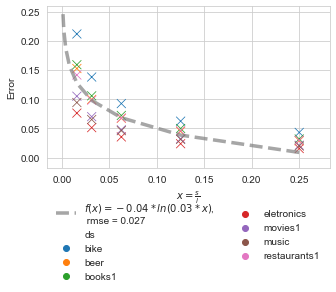

In [52]:
q2 = lambda x, a, b , c : a * np.log(b * x) + c
# a,b,c = exponential_regression2var(q2, X, y , Xg , yg) #original
# a,b,c = exponential_regression2var(q2, X, y , labelg, Xg , yg, eq_label=r'$f(x) = {:.2f} * ln( {:.2f} * x) {:.2f}$')
a,b,c = exponential_regression2var(q2, X, y , labelg, Xg , yg, eq_label=r'$f(x) = {:.2f} * ln( {:.2f} * x) $')

dados originais

D:\Programas\Anaconda3\envs\utils\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


[-0.0428763   0.03063594 -0.2000835 ]


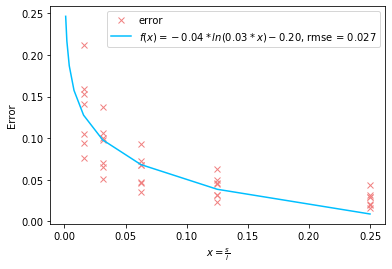

In [20]:
q2 = lambda x, a, b , c : a * np.log(b * x) + c
# a,b,c = exponential_regression2var(q2, X, y , Xg , yg) #original
a,b,c = exponential_regression2var(q2, X, y , Xg , yg, eq_label=r'$f(x) = {:.2f} * ln( {:.2f} * x) {:.2f}$')


# q2 = lambda x, a, b: a * np.log(b * x)
# a, b = exponential_regression2var_v1(q2, Xg, yg)
# plot_episilon_approximation(a, b)



0
1
2


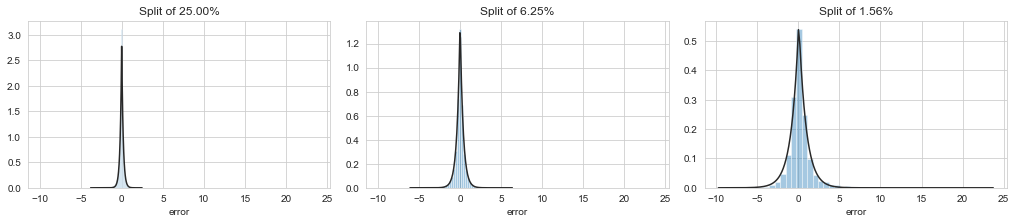

In [162]:
plot_error_epsilon_distribution(df,marcas=[1, 3, 5],fs=(14,3))

dados originais

0
1
2


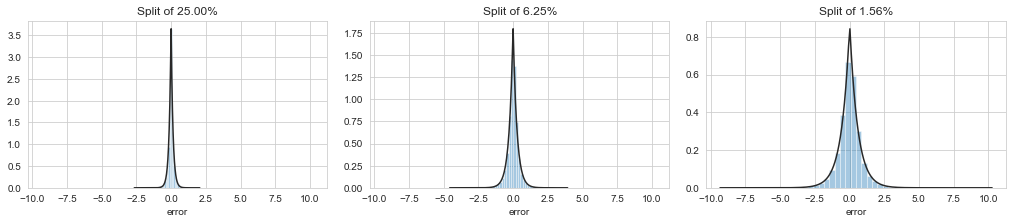

In [100]:
# plot_error_epsilon_distribution(df,marcas=[1, 3, 4, 5],fs=(5,5))
# plot_error_epsilon_distribution_original(df,marcas=[1, 3, 4, 5],fs=(6,5))
plot_error_epsilon_distribution(df,marcas=[1, 3, 5],fs=(14,3))